In [1]:
import xarray as xr
import numpy as np
import scipy as sp
import rasterio as rio
import os
import matplotlib.pyplot as plt
import geopandas as gpd

In [2]:
gpd = gpd.read_file(r'E:\risk_evaluation\scripts\outputs\RESEARCH_AREA\area.shp')

In [3]:
def read_precip() -> np.ndarray:
    data_frame_list = []
    for i in ["pre_2000_2002.nc", "pre_2003_2005.nc", "pre_2006_2008.nc", "pre_2009_2011.nc", "pre_2012_2014.nc", "pre_2015_2017.nc"]:
        filename  = os.path.join(r"E:\risk_evaluation\scripts\outputs\PRECIP",i)
        data_frame = xr.open_dataset(filename,decode_coords="all")
        data_frame = data_frame.rio.clip(gpd.geometry.values,crs=gpd.crs,drop=True).to_array()[0,:,:,:]
        data_frame_list.append(data_frame)
    return np.concatenate(data_frame_list,axis=0)

In [4]:
example_frame = xr.open_dataset(r"E:\risk_evaluation\scripts\outputs\PRECIP\pre_2000_2002.nc",decode_coords="all")
example_frame = example_frame.rio.clip(gpd.geometry.values,crs=gpd.crs,drop=True)
example_frame

<xarray.Dataset>
Dimensions:      (lat: 1587, lon: 1483, time: 36)
Coordinates:
  * lat          (lat) float64 42.61 42.6 42.6 42.59 ... 29.42 29.41 29.4 29.4
  * lon          (lon) float64 110.4 110.4 110.4 110.4 ... 122.7 122.7 122.7
  * time         (time) float64 1.0 2.0 3.0 4.0 5.0 ... 32.0 33.0 34.0 35.0 36.0
    spatial_ref  int32 0
Data variables:
    pre          (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan

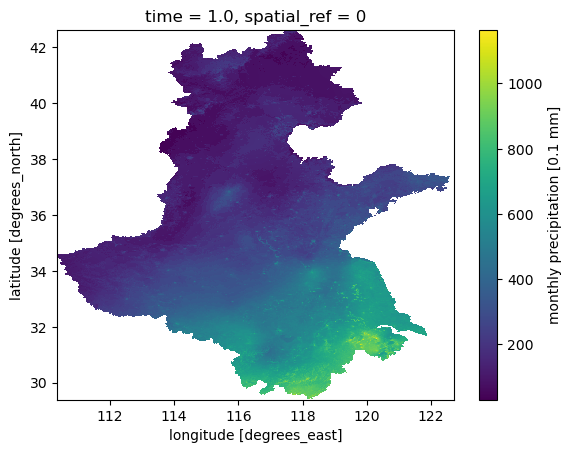

In [5]:
example_frame.loc[{"time":1}].pre.plot()

In [6]:
precip_array = read_precip()[0:192, :,:]*0.1

In [7]:
precip_array = read_precip()[0:192,:,:]*0.1


precip_avg_7_8 = []

for i in range(0,16):
    july_precip = precip_array[i*12+6,:,:]
    august_precip = precip_array[i*12+7,:,:]
    avg_precip = (july_precip+august_precip)/2
    precip_avg_7_8.append((avg_precip))

precip_avg_7_8 = np.array(precip_avg_7_8)

precip_avg_7_8 = np.average(precip_avg_7_8,axis=0)

precip_variability = []

for i in range(0,16):
    august_precip = precip_array[i*12+7,:,:]
    september_precip = precip_array[i*12+8,:,:]
    avg_precip = (july_precip+august_precip)/2
    precip_variability.append((avg_precip-precip_avg_7_8)/precip_avg_7_8)

precip_variability = np.array(precip_variability)

In [8]:
np.nanmax(precip_variability)

0.82666993

In [9]:
np.nanmin(precip_variability)

-0.6551154

In [10]:
np.arange(1,17)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

In [11]:
precip_variability.shape

(16, 1587, 1483)

In [12]:
for p in range(0,precip_variability.shape[0]):
    pre_per_year = precip_variability[p]
    exp_var = xr.Dataset(
        {
        "pre_var":(["y","x"],pre_per_year)
    },
    coords={
        "y":example_frame.lat.data,
        "x":example_frame.lon.data
    }
    )
    exp_var.rio.write_crs("epsg:4326", inplace=True).rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True).rio.write_coordinate_system(inplace=True).rio.write_transform(inplace=True)

    exp_var.rio.to_raster("var/"+str(p)+".tif")

RasterioIOError: Attempt to create new tiff file 'var/0.tif' failed: No such file or directory

In [13]:
x = precip_variability
exp_var = xr.Dataset(
        {
        "pre_var":(["time","y","x"],x)
    },
    coords={
        "time":np.arange(1,17),
        "y":example_frame.lat.data,
        "x":example_frame.lon.data
    }
)
exp_var.rio.write_crs("epsg:4326", inplace=True).rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True).rio.write_coordinate_system(inplace=True).rio.write_transform(inplace=True)

<xarray.Dataset>
Dimensions:      (time: 16, y: 1587, x: 1483)
Coordinates:
  * time         (time) int32 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16
  * y            (y) float64 42.61 42.6 42.6 42.59 ... 29.42 29.41 29.4 29.4
  * x            (x) float64 110.4 110.4 110.4 110.4 ... 122.7 122.7 122.7 122.7
    spatial_ref  int32 0
Data variables:
    pre_var      (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan

In [14]:
exp_var.to_netcdf(
    r"E:\risk_evaluation\scripts\outputs\PRECIP_VAR\pre_var.nc")